## Neural Style Transfer

Neural Style Transfer's first method is centred on directly optimising the pixel values of the image. Instead of training a network, we use one that has already been pretrained, and the loss is determined by using the features that have been extracted from it.

But because we have to perform optimisation for each new style-content image pair, this approach is incredibly inefficient. Johnson et al. suggested utilising a feed-forward network to carry out Style Transfer. Therefore, we run the image through an Image Transformation Network and learn the weights of this network instead of optimising the image pixels. This is the strategy I used to complete this assignment. The sole disadvantage of this approach is that we would have to train a new network in order to adapt to a new art style because the network is limited to a single style.

Additional research expands this to a greater number of styles per network, but due to time and resource limitations, I chose the less complicated method.

We use one style image and a dataset of content images for training. Three different kinds of losses exist in our goal.

1- Content Loss
2- Style Loss
3- Total Variation Loss

A pre-trained VGG network's features are the basis for these losses. The majority of its foundation is empirical data. A well-trained CNN's earlier layers perform well at identifying minute details or, in a sense, the image's content. We use the Image Transformation Network to transform the input image, the style image, and the content image in each training example. The best results are obtained when the input image is taken empirically as the content image. The content loss is just the MSE between the feature responses of specific layers (for VGG16, _relu_1_2_ and _relu_2_2_ seem to work well and are the most used in literature). We feed the transformed image and the content image into the pretrained VGG.

The correlation matrices of the feature responses are made similar in order to capture the style. More precisely, we calculate the correlation matrix of $C$ features of shape $HW$ if we have activations of some layer in the shape $C \times H \times W$. We carry out this action for activations from layers _relu_3_3_ and _relu_4_3_ in the instance of VGG16.

All that the TV Loss does is encourage spatial smoothness in the final image by acting as a regularizer.

In [5]:
import numpy as np
import torch
from utils import *

# Outlined in Johnson et al.
from transformer import TransformerNet

# pretrained VGG to extract features form relu_1_2, relu_2_2, relu_3_3 and relu_4_3
from vgg import PerceptualLossNet

from torch.optim import Adam
import time
from PIL import Image
import os
import pickle
from torch.utils.data import random_split

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

## Model Architecture
All that's required for the perceptual loss network is a VGG16 pretrained on ImageNet. I used the Johnson et al. network for the Image Transformation Net, making a few modifications such as switching from Batch Norm to Instance Norm and other changes that are known to produce better results based on research and follow-up papers. 

To downsample the image, we have three convolution layers and then instance norm layers. Residual Blocks come next, and then Nearest Neighbour upsampling is used, followed by convolution layers, to achieve an output that is identical in shape to the input. 

In [12]:
# Hyperparameters
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "data"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style_image.jpeg"
CONTENT_IMAGE_PATH = "content.jpeg"
BATCH_SIZE = 4
CONTENT_WEIGHT = 1e0
STYLE_WEIGHT = 4e5
TV_WEIGHT = 1e-6
LR = 0.001
SAVE_MODEL_PATH = "checkpoints"
SAVE_IMAGE_PATH = "image_outputs"
CHECKPOINT_FREQ = 150
LOG_FREQ = 50

# Setting the seed value for reproducibility
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

## Training

The training logic is all contained in this class. With approximately 83k images, the original MSCOCO dataset used in the literature for these models is enormous. I used a very small version of this dataset, with Training Set Size: 12417 and Validation Set Size: 165, as I did not have access to any GPUs. We use a painting by Picasso, saved as style_image.jpeg, for the style image.

Because the quality of the output cannot be measured objectively and is instead dependent on personal preference and aesthetics, style transfer is by its very nature an ill-posed problem. We are limited to using the loss function as a stand-in for performance measurement as a result.

The majority of the hyperparameters were taken from the paper because I lacked the tools necessary to properly tune them. We monitor the validation loss during the model selection process and select the model with the lowest validation loss.

In [13]:
class StyleTransfer:
    def __init__(
        self,
        num_epochs=NUM_EPOCHS,
        image_size=TRAIN_IMAGE_SIZE,
        dataset_path=DATASET_PATH,
        style_image_path=STYLE_IMAGE_PATH,
        content_image_path=CONTENT_IMAGE_PATH,
        batch_size=BATCH_SIZE,
        style_weight=STYLE_WEIGHT,
        content_weight=CONTENT_WEIGHT,
        tv_weight=TV_WEIGHT,
        log_freq=LOG_FREQ,
        checkpoint_freq=CHECKPOINT_FREQ,
        lr=LR,
        save_model_path=SAVE_MODEL_PATH,
        save_image_path=SAVE_IMAGE_PATH
    ):
        self.epochs = num_epochs
        self.image_size = image_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.dataset_path = dataset_path
        self.style_image_path = style_image_path
        self.content_image_path = content_image_path
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.tv_weight = tv_weight
        self.lr = lr
        self.log_freq = log_freq
        self.checkpoint_freq = checkpoint_freq
        self.save_model_path = save_model_path
        self.save_image_path = save_image_path

        # load data
        print("Loading Data...")
        self.train_loader, self.val_loader = get_training_data_loader(dataset_path, image_size, batch_size)
        print("Data Loaded Successfully \n")
        
        # instantiate networks
        self.transformer_net = TransformerNet().train().to(self.device)
        self.perceptual_loss_net = PerceptualLossNet(requires_grad=False).to(self.device)

        self.optimizer = Adam(self.transformer_net.parameters())

        # Compute Gram matrices for the style image
        style_img = prepare_img(style_image_path, self.device, batch_size=batch_size)
        style_img_set_of_feature_maps = self.perceptual_loss_net(style_img)
        self.target_style_representation = [gram_matrix(x) for x in style_img_set_of_feature_maps]
        
        # This image is used to keep track of the subjective performance over the iteration
        # sotred in the directory "save_image_path" after every log_iter iterations
        self.test_image = prepare_img(content_image_path, self.device)
        
        self.mse_loss = torch.nn.MSELoss(reduction='mean')

        self.best_val_loss = None
        
        self.history = {
            'content_loss_t': [],
            'style_loss_t': [],
            'tv_loss_t': [],
            'total_loss_t': [],
            'total_loss_v' : []
        }
    
    
    def train(self):
        print("Training Started...\n")
        
        ts = time.time()
        
        acc_content_loss, acc_style_loss, acc_tv_loss = [0., 0., 0.]
        
        for epoch in range(self.epochs):
            for batch_id, (content_batch, _) in enumerate(self.train_loader):
                # get ouput of transform_net
                content_batch = content_batch.to(self.device)
                stylized_batch = self.transformer_net(content_batch)

                # feed batch of style and content images to the vgg net
                content_batch_set_of_feature_maps = self.perceptual_loss_net(content_batch)
                stylized_batch_set_of_feature_maps = self.perceptual_loss_net(stylized_batch)

                # compute content loss
                target_content_representation = content_batch_set_of_feature_maps.relu2_2
                current_content_representation = stylized_batch_set_of_feature_maps.relu2_2
                content_loss = self.content_weight * self.mse_loss(target_content_representation, current_content_representation)
                acc_content_loss += content_loss.item()
                
                # compute gram matrices and style loss
                style_loss = 0.0
                current_style_representation = [gram_matrix(x) for x in stylized_batch_set_of_feature_maps]
                for gram_gt, gram_hat in zip(self.target_style_representation, current_style_representation):
                    style_loss += self.mse_loss(gram_gt, gram_hat)
                style_loss /= len(self.target_style_representation)
                style_loss *= self.style_weight
                acc_style_loss += style_loss.item()

                # compute tv loss
                tv_loss = self.tv_weight * total_variation(stylized_batch)
                acc_tv_loss += tv_loss.item()

                # backprop
                total_loss = content_loss + style_loss + tv_loss
                total_loss.backward()
                self.optimizer.step()

                self.optimizer.zero_grad()
                
                if (batch_id + 1) % self.log_freq == 0:
                    with torch.no_grad():
                        self.history['content_loss_t'].append(acc_content_loss / self.log_freq)
                        self.history['style_loss_t'].append(acc_style_loss / self.log_freq)
                        self.history['tv_loss_t'].append(acc_tv_loss / self.log_freq)
                        self.history['total_loss_t'].append((acc_content_loss + acc_style_loss + acc_tv_loss) / self.log_freq)

                        self.transformer_net.eval()
                        stylized_test = self.transformer_net(self.test_image).cpu().numpy()[0]
                        val_loss = self.val_loss()
                        self.transformer_net.train()
                        stylized = post_process_image(stylized_test)
                        stylized_image = Image.fromarray(stylized)

                        stylized_image.save(os.path.join(self.save_image_path, f"iter-{batch_id + 1}.jpeg"))
                        
                        
                        
                        if self.best_val_loss is None or val_loss < self.best_val_loss:
                            self.best_val_loss = val_loss
                            torch.save(self.transformer_net.state_dict(), "best_model.pth")
                            
                        print(f'Iter : [{batch_id + 1}/{len(self.train_loader)}]')
                        print('---------------------\n')
                        print(f'Time Elapsed : {(time.time() - ts) / 60:.2f} min)')
                        print('Training Loss :')
                        print(f'\tContent Loss : {acc_content_loss / self.log_freq}')
                        print(f'\tStyle Loss : {acc_style_loss / self.log_freq}')
                        print(f'\tTV Loss : {acc_tv_loss / self.log_freq}')
                        print(f'\tTotal Loss : {(acc_content_loss + acc_style_loss + acc_tv_loss) / self.log_freq}')
                        print(f'Validation Loss : {val_loss}\n\n')
                    
                        
                        acc_content_loss, acc_style_loss, acc_tv_loss = [0., 0., 0.]

                
                if (batch_id + 1) % self.checkpoint_freq == 0:
                    torch.save(self.transformer_net.state_dict(),
                               os.path.join(self.save_model_path, f"iter-{batch_id + 1}.pth"))


                            
    def val_loss(self):
        val_loss = 0.0
        for batch_id, (content_batch, _) in enumerate(self.val_loader):
            content_batch = content_batch.to(self.device)
            stylized_batch = self.transformer_net(content_batch)
            
            content_batch_set_of_feature_maps = self.perceptual_loss_net(content_batch)
            stylized_batch_set_of_feature_maps = self.perceptual_loss_net(stylized_batch)
            
            target_content_representation = content_batch_set_of_feature_maps.relu2_2
            current_content_representation = stylized_batch_set_of_feature_maps.relu2_2
            content_loss = self.content_weight * self.mse_loss(target_content_representation, current_content_representation)

            style_loss = 0.0
            current_style_representation = [gram_matrix(x) for x in stylized_batch_set_of_feature_maps]
            for gram_gt, gram_hat in zip(self.target_style_representation, current_style_representation):
                style_loss += self.mse_loss(gram_gt, gram_hat)
            style_loss /= len(self.target_style_representation)
            style_loss *= self.style_weight
            
            tv_loss = self.tv_weight * total_variation(stylized_batch)

            val_loss += (content_loss + style_loss + tv_loss).item()
            
        val_loss /= len(self.val_loader)
        self.history['total_loss_v'].append(val_loss)
                
        return val_loss

In [14]:
style_transfer = StyleTransfer()

Loading Data...
Training Set Size : 12417
Validation Set Size : 165
Data Loaded Successfully 



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\aravi/.cache\torch\hub\checkpoints\vgg16-397923af.pth


In [15]:
style_transfer.train()

Training Started...

Iter : [50/3104]
---------------------

Time Elapsed : 5.77 min)
Training Loss :
	Content Loss : 5.934230990409851
	Style Loss : 22.252575950622557
	TV Loss : 0.010350680965930224
	Total Loss : 28.19715762199834
Validation Loss : 15.733688912740568


Iter : [100/3104]
---------------------

Time Elapsed : 11.45 min)
Training Loss :
	Content Loss : 6.26154577255249
	Style Loss : 7.451888561248779
	TV Loss : 0.016604524552822113
	Total Loss : 13.730038858354092
Validation Loss : 12.597650248829911


Iter : [150/3104]
---------------------

Time Elapsed : 17.46 min)
Training Loss :
	Content Loss : 6.3648433589935305
	Style Loss : 4.920478434562683
	TV Loss : 0.02767215568572283
	Total Loss : 11.312993949241935
Validation Loss : 10.680499867695135


Iter : [200/3104]
---------------------

Time Elapsed : 24.43 min)
Training Loss :
	Content Loss : 6.170740432739258
	Style Loss : 3.595876622200012
	TV Loss : 0.035476987957954405
	Total Loss : 9.802094042897224
Validation

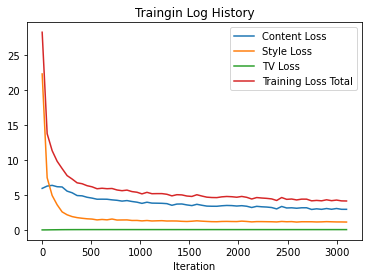

In [16]:
from matplotlib import pyplot as plt

log_dict = style_transfer.history

x = np.linspace(1, len(log_dict['content_loss_t'])*style_transfer.log_freq, len(log_dict['content_loss_t']))
plt.plot(x, log_dict['content_loss_t'], label='Content Loss')
plt.plot(x, log_dict['style_loss_t'], label='Style Loss')
plt.plot(x, log_dict['tv_loss_t'], label='TV Loss')
plt.plot(x, log_dict['total_loss_t'], label='Training Loss Total')

plt.xlabel('Iteration')
plt.title('Traingin Log History')
plt.legend()

## Improvements and Further Scope

- There were significantly fewer feasible methods in the literature to explore due to severe time and resource constraints. Therefore, better results would have come from a more extensive literature review.

- This method itself could be made even more effective with proper hyperparameter tweaking. There may have been less loss if an LR scheduler had been used as well.

- Overall, with more time and adequate processing power, a lot more experimentation could have been conducted. 